In [93]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [94]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [95]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-123.28736502403991,36.53106212747138],
        [-120.57374197716491,36.53106212747138],
        [-120.57374197716491,38.629116592353306],
        [-123.28736502403991,38.629116592353306],
        [-123.28736502403991,36.53106212747138]]])

In [96]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")


In [97]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [98]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")


In [99]:
#traing data for July
ground_truth= image_LANDSAT8.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [100]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [101]:
print(points.size().getInfo())

print(points.first().getInfo())

5000
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.63707972816317, 38.31258651670711]}, 'id': '0', 'properties': {'B1': 478.5, 'B10': 3056.5, 'B11': 3032, 'B2': 594, 'B3': 940, 'B4': 843, 'B5': 3500, 'B6': 2249.5, 'B7': 1434, 'NO2_column_number_density': 9.315050192526542e-05, 'sr_aerosol': 160}}


In [102]:
print(points_sep.size().getInfo())

print(points_sep.first().getInfo())

5000
{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-121.63707972816317, 38.31258651670711]}, 'id': '0', 'properties': {'B1': 669.5, 'B10': 3083, 'B11': 3057.5, 'B2': 774, 'B3': 977, 'B4': 1133, 'B5': 1591.5, 'B6': 2317.5, 'B7': 2026.5, 'NO2_column_number_density': 8.35345927043818e-05, 'sr_aerosol': 96}}


In [103]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol
0,478.5,3056.5,3032.0,594.0,940.0,843.0,3500.0,2249.5,1434.0,0.000093,160
1,260.5,3060.0,3035.5,333.0,539.5,523.0,1883.5,1556.5,927.0,0.000088,177
2,453.0,3065.5,3036.0,651.5,1093.5,1369.0,2180.5,2280.5,1681.0,0.000101,145
3,655.5,3130.0,3095.5,877.5,1334.0,1932.5,3458.0,3783.0,2388.5,0.000092,98
4,3086.0,2859.5,2862.5,3078.0,2960.0,2921.5,2900.5,2503.5,1881.5,0.000063,38
...,...,...,...,...,...,...,...,...,...,...,...
4995,301.5,3069.5,3050.0,458.0,811.5,1154.5,3075.5,2875.0,1591.0,0.000094,96
4996,626.0,3076.0,3042.5,870.5,1289.0,1612.0,2946.5,3258.0,2413.0,0.000102,192
4997,4410.5,2841.5,2842.5,4431.0,4454.0,4542.0,4672.5,3779.0,2904.5,0.000072,8
4998,3839.0,2840.5,2837.5,3852.0,3833.0,3888.0,4006.5,3633.0,3190.5,0.000072,8


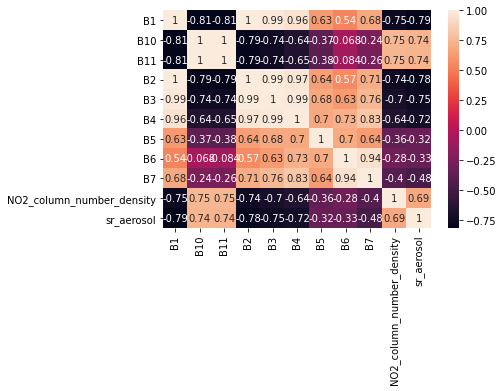

In [104]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

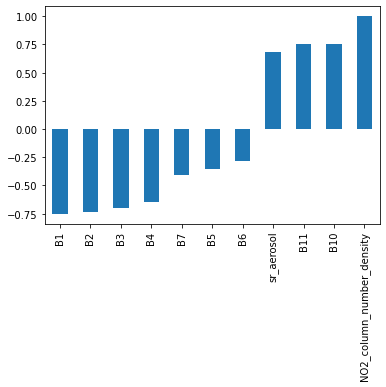

In [105]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [106]:
dtale.show(df)

In [117]:
df.to_csv('df.csv')

Executing shutdown due to inactivity...


2021-06-20 13:53:31,883 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-06-20 13:53:31,904 - INFO     - Executing shutdown...


In [107]:
df.isnull().sum()

B1                           0
B10                          0
B11                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
NO2_column_number_density    0
sr_aerosol                   0
dtype: int64

In [108]:
X=df.drop('B1',axis=1).values
y=df['B1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [109]:
model=Sequential()
model.add(Dense(10,activation='relu'))
model.compile(loss='mse',optimizer='adam')
model.fit(x=X_train,y=y_train, epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
110/110 [==============================] - 0s 2ms/step - loss: 4501435.0000 - val_loss: 4758589.0000
Epoch 2/100
110/110 [==============================] - 0s 833us/step - loss: 4500076.5000 - val_loss: 4756881.0000
Epoch 3/100
110/110 [==============================] - 0s 1ms/step - loss: 4498317.5000 - val_loss: 4755095.0000
Epoch 4/100
110/110 [==============================] - 0s 1ms/step - loss: 4496655.0000 - val_loss: 4753413.0000
Epoch 5/100
110/110 [==============================] - 0s 869us/step - loss: 4495053.5000 - val_loss: 4751761.0000
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: 4493476.5000 - val_loss: 4750137.5000
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: 4491913.5000 - val_loss: 4748499.0000
Epoch 8/100
110/110 [==============================] - 0s 1ms/step - loss: 4490357.0000 - val_loss: 4746896.0000
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 4488812.0000 - va

Text(0, 0.5, 'Loss')

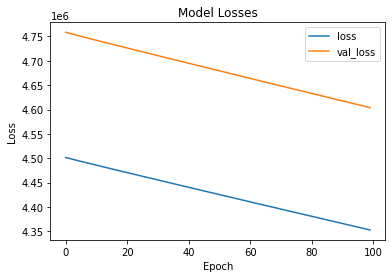

In [110]:
losses=pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [111]:
X_train.shape

(3500, 10)

In [112]:
y_train.shape

(3500,)

In [113]:
prediction=model.predict(X_test)

In [114]:
prediction.shape

(1500, 10)

In [115]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylim([-0.0001,0.00025])
plt.ylabel('NO2_column_number_density')

ValueError: y_true and y_pred have different number of output (1!=10)

In [ ]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
NO2_column_number_density=df['NO2_column_number_density']

In [ ]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

In [ ]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [ ]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

## Start Mutlti-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [ ]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")

In [ ]:
ground_truth= image_LANDSAT8.addBands(image_S5P)

In [ ]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 20000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [ ]:
print(points.size().getInfo())

In [ ]:
print(points.first().getInfo())

In [ ]:
df = geemap.ee_to_pandas(points)
df

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [ ]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

In [ ]:
# defining LinearRegression model
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

# k-Nearest Neighbors for Multioutput Regression

In [ ]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

# Decision Tree for Multioutput Regression

In [ ]:
# define model
model = DecisionTreeRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
prediction.shape

In [ ]:
y_test.shape